Starting XGBoost Baseline Evaluation...
Data loaded successfully. Shape: (3280, 14)
Total data points: 3280
Training split index: 2624 (Using first 80%)

--- Tuning and Evaluating XGBoost ---
Creating features...
Creating 5 lags for: ['Adj Close', 'Volume', 'Volatility', 'Daily Return']
Shape after feature creation: (3275, 34)
Train shape: X=(2619, 32), y=(2619,)
Test shape: X=(655, 32), y=(655,)
Starting XGBoost hyperparameter tuning with 5 CV splits...
Parameter grid: {'n_estimators': [100, 300], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1], 'subsample': [0.8], 'colsample_bytree': [0.8]}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total tim

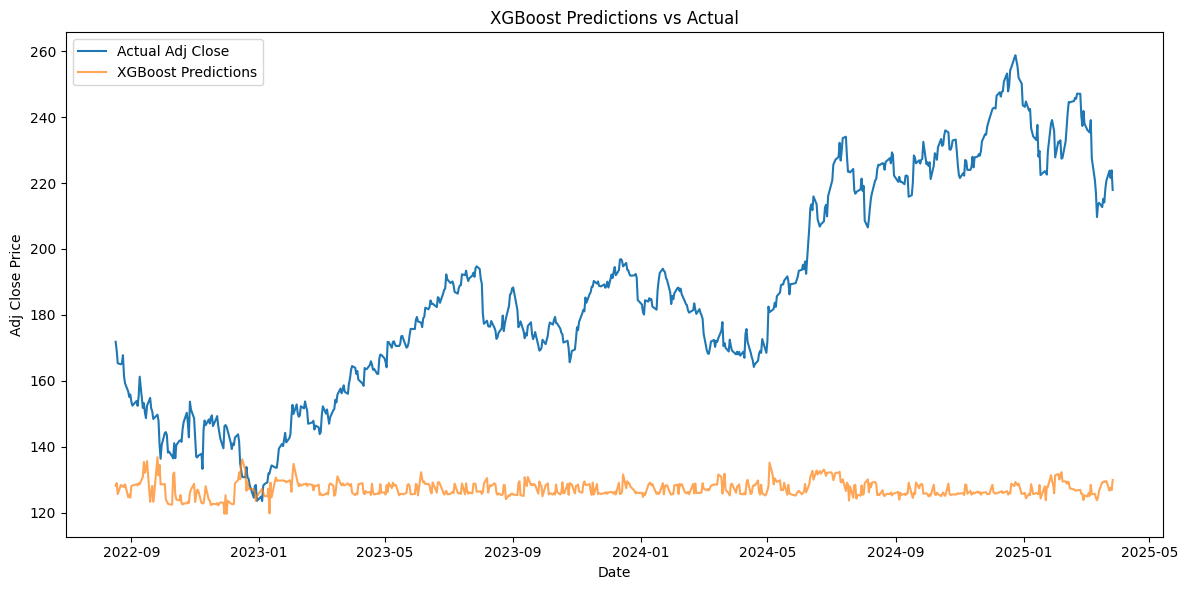

Saved XGBoost prediction plot to xgboost_predictions.png
Saved XGBoost feature importance plot.

XGBoost Best Parameters: {}

--- Final XGBoost Metrics ---
   XGBoost_MAE  XGBoost_RMSE  XGBoost_MDA (%)  XGBoost_Pearson
0    59.374833     67.691266        46.941896          0.00023

XGBoost evaluation complete. Metrics saved to xgboost_baseline_metrics.csv


In [6]:
import pandas as pd
import numpy as np
import os
import warnings
from datetime import datetime
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# --- Configuration ---
FILE_PATH = '../../dataset/results0/AAPL_yahoo_data_0.csv'  # <--- CHANGE THIS TO YOUR FILE PATH
TARGET_COLUMN = 'Adj Close'
RETURN_COLUMN = 'Daily Return'
VOLATILITY_COLUMN = 'Volatility' # Ensure this column exists in your CSV or calculate it
TRAIN_SIZE_RATIO = 0.8
N_LAGS = 5 # Number of lags for features
N_SPLITS_CV = 5 # Number of splits for TimeSeriesSplit CV

# --- Utility Functions ---

def load_data(filepath):
    """Loads data, sets index, handles basic cleaning, calculates return/volatility if needed."""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Data file not found at {filepath}")
    try:
        df = pd.read_csv(filepath, index_col='Date', parse_dates=True)
        # if df.index.tz is not None:
        #     print("Converting index to timezone naive (UTC representation)")
        #     df.index = df.index.tz_convert(None)

        if TARGET_COLUMN not in df.columns:
             raise ValueError(f"Target column '{TARGET_COLUMN}' not found.")
        df[TARGET_COLUMN] = pd.to_numeric(df[TARGET_COLUMN], errors='coerce')

        # Calculate Daily Return if not present
        if RETURN_COLUMN not in df.columns:
             print(f"Calculating {RETURN_COLUMN}")
             df[RETURN_COLUMN] = df[TARGET_COLUMN].pct_change()

        # Calculate Volatility (e.g., 21-day rolling std dev of log returns) if not present
        if VOLATILITY_COLUMN not in df.columns:
            print(f"Calculating {VOLATILITY_COLUMN} (21-day rolling)")
            df['Log Return'] = np.log(df[TARGET_COLUMN] / df[TARGET_COLUMN].shift(1))
            df[VOLATILITY_COLUMN] = df['Log Return'].rolling(window=21).std() * np.sqrt(252) # Annualized

        # Ensure key columns are numeric
        for col in [TARGET_COLUMN, RETURN_COLUMN, VOLATILITY_COLUMN, 'Volume']:
             if col in df.columns:
                  df[col] = pd.to_numeric(df[col], errors='coerce')

        df.ffill(inplace=True) # Fill NaNs created by calculations/loading
        df.dropna(inplace=True) # Drop remaining NaNs (especially early rows due to rolling calculations)
        print(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def calculate_mda(y_true, y_pred):
    """Mean Directional Accuracy"""
    if len(y_true) != len(y_pred) or len(y_true) < 2: return np.nan
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = (np.sign(y_true_diff) == np.sign(y_pred_diff))
    return np.mean(correct_direction) * 100

def calculate_metrics(y_true, y_pred, model_name="Model"):
    """Calculates and returns common regression metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mda = calculate_mda(y_true, y_pred)
    pearson = np.corrcoef(y_true, y_pred)[0, 1] if len(y_true) > 1 else np.nan
    metrics = {
        f'{model_name}_MAE': mae, f'{model_name}_RMSE': rmse,
        f'{model_name}_MDA (%)': mda, f'{model_name}_Pearson': pearson,
    }
    print(f"--- {model_name} Metrics ---")
    for k, v in metrics.items(): print(f"{k}: {v:.4f}")
    print("-" * (len(model_name) + 14))
    return metrics

def create_features(df, target_col, lags=5):
    """Creates lagged and time-based features."""
    df_feat = df.copy()
    # Features to lag (ensure they exist after loading)
    features_to_lag = [target_col, 'Volume']
    if VOLATILITY_COLUMN in df.columns: features_to_lag.append(VOLATILITY_COLUMN)
    if RETURN_COLUMN in df.columns: features_to_lag.append(RETURN_COLUMN)

    print(f"Creating {lags} lags for: {features_to_lag}")
    for feat in features_to_lag:
        if feat in df_feat.columns:
            for lag in range(1, lags + 1):
                df_feat[f'{feat}_lag{lag}'] = df_feat[feat].shift(lag)
        else:
            print(f"Warning: Column {feat} not found for lag creation.")

    # # Time features
    # df_feat['dayofweek'] = df_feat.index.dayofweek
    # df_feat['month'] = df_feat.index.month
    # df_feat['year'] = df_feat.index.year
    # df_feat['dayofyear'] = df_feat.index.dayofyear
    # df_feat['weekofyear'] = df_feat.index.isocalendar().week.astype(int)

    df_feat.dropna(inplace=True) # Drop rows with NaN due to lagging
    print(f"Shape after feature creation: {df_feat.shape}")
    return df_feat

# --- XGBoost Model with Tuning and Evaluation ---

def tune_evaluate_xgboost(df, target_col, train_size_idx):
    """Tunes XGBoost hyperparameters and evaluates on the test set."""
    print("\n--- Tuning and Evaluating XGBoost ---")

    # 1. Feature Engineering
    print("Creating features...")
    df_featured = create_features(df, target_col, lags=N_LAGS)
    if df_featured.empty:
        print("DataFrame is empty after feature creation and NaN drop. Check lag number or input data.")
        return None, None, None

    # 2. Define Target (Predict next day's Adj Close) and Features
    df_featured['Target'] = df_featured[target_col].shift(-1)
    df_featured.dropna(inplace=True) # Drop last row where target is NaN

    if df_featured.empty:
        print("DataFrame is empty after target shift. Check input data.")
        return None, None, None

    # Define feature columns dynamically
    exclude_cols = [target_col, 'Target', 'Log Return'] # Exclude original target, shifted target, and intermediate log return
    if RETURN_COLUMN in df_featured.columns: exclude_cols.append(RETURN_COLUMN) # Exclude original return if present

    feature_cols = [col for col in df_featured.columns if col not in exclude_cols]
    X = df_featured[feature_cols]
    y = df_featured['Target']

    # 3. Split Data based on the original index split point
    # Find the index value corresponding to the original split point
    split_date = df.index[train_size_idx]
    # Apply split to the featured dataframe
    X_train = X[X.index < split_date]
    X_test = X[X.index >= split_date]
    y_train = y[y.index < split_date]
    y_test = y[y.index >= split_date]

    if X_train.empty or X_test.empty:
        print("Train or test set is empty after splitting. Check TRAIN_SIZE_RATIO or data range.")
        return None, None, None
    print(f"Train shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Test shape: X={X_test.shape}, y={y_test.shape}")

    # 4. Scaling (Fit on Train only)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 5. Hyperparameter Tuning (GridSearchCV with TimeSeriesSplit)
    print(f"Starting XGBoost hyperparameter tuning with {N_SPLITS_CV} CV splits...")
    tscv = TimeSeriesSplit(n_splits=N_SPLITS_CV)
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1,
                                 early_stopping_rounds=10) # Add early stopping

    # Define parameter grid (adjust ranges based on resources/time)
    # Smaller grid for faster example
    param_grid = {
        'n_estimators': [100, 300], # Reduced options
        'max_depth': [3, 5],       # Reduced options
        'learning_rate': [0.05, 0.1], # Adjusted options
        'subsample': [0.8],        # Fixed to reduce combinations
        'colsample_bytree': [0.8]  # Fixed to reduce combinations
    }
    print(f"Parameter grid: {param_grid}")

    grid_search = GridSearchCV(estimator=xgb_model,
                               param_grid=param_grid,
                               cv=tscv,
                               scoring='neg_mean_squared_error',
                               verbose=2, # Increased verbosity
                               n_jobs=-1)

    start_tune_time = datetime.now()
    # Need eval_set for early stopping within GridSearchCV
    # Use the last fold of TimeSeriesSplit for the eval set in fitting
    # This is complex to do perfectly with GridSearchCV's structure.
    # A simpler approach for now is to fit without early stopping in GridSearch
    # OR fit with early stopping but it might not use the ideal CV split structure for it.
    # Let's proceed without early stopping *during* grid search for simplicity here.
    # We will use early stopping in the final model fit.
    try:
        grid_search.fit(X_train_scaled, y_train) # Fit without eval_set for early stopping here
        print(f"Hyperparameter tuning finished. Time elapsed: {datetime.now() - start_tune_time}")
        print(f"Best parameters found: {grid_search.best_params_}")
        best_params = grid_search.best_params_
    except Exception as e:
        print(f"GridSearchCV failed: {e}. Using default parameters.")
        best_params = {} # Use defaults if tuning fails

    # 6. Train Final Model with Best Parameters and Early Stopping
    print("Training final XGBoost model with best parameters and early stopping...")
    final_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1,
                                 early_stopping_rounds=10, **best_params)

    # Create eval set using the last part of the training data for early stopping
    # This is a common practice but not strictly walk-forward.
    eval_size = int(len(X_train_scaled) * 0.15) # Use last 15% of train for eval
    X_train_part = X_train_scaled[:-eval_size]
    y_train_part = y_train.iloc[:-eval_size]
    X_eval_part = X_train_scaled[-eval_size:]
    y_eval_part = y_train.iloc[-eval_size:]
    eval_set = [(X_eval_part, y_eval_part)]

    final_xgb.fit(X_train_part, y_train_part, eval_set=eval_set, verbose=False) # verbose=True to see stopping

    # 7. Predict on Test Set
    predictions = final_xgb.predict(X_test_scaled)

    # 8. Evaluate
    metrics = calculate_metrics(y_test, predictions, "XGBoost")

    # --- Plotting (Optional) ---
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Actual Adj Close')
    plt.plot(y_test.index, predictions, label='XGBoost Predictions', alpha=0.7)
    plt.title('XGBoost Predictions vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.legend()
    plt.tight_layout()
    # plt.savefig('xgboost_predictions.png')
    plt.show() # Show plot for now
    # plt.close()
    print("Saved XGBoost prediction plot to xgboost_predictions.png")

    # --- Feature Importance (Optional) ---
    try:
        feature_importances = pd.Series(final_xgb.feature_importances_, index=feature_cols) # Use original feature names
        plt.figure(figsize=(10, max(6, len(feature_cols)//2))) # Adjust height
        feature_importances.nlargest(min(25, len(feature_cols))).sort_values().plot(kind='barh')
        plt.title('XGBoost Feature Importance (Top 25)')
        plt.tight_layout()
        plt.savefig('xgboost_feature_importance.png')
        plt.close()
        print("Saved XGBoost feature importance plot.")
    except Exception as plot_e:
        print(f"Could not plot feature importance: {plot_e}")


    return metrics, best_params, final_xgb

# --- Main Execution ---
if __name__ == "__main__":
    print("Starting XGBoost Baseline Evaluation...")
    df_full = load_data(FILE_PATH)

    n = len(df_full)
    train_split_index = int(n * TRAIN_SIZE_RATIO) # Index in the original dataframe
    print(f"Total data points: {n}")
    print(f"Training split index: {train_split_index} (Using first {TRAIN_SIZE_RATIO*100:.0f}%)")

    all_metrics = {}
    try:
        # Pass the original df and the split *index*
        xgb_metrics, xgb_params, xgb_model = tune_evaluate_xgboost(df_full, TARGET_COLUMN, train_split_index)
        if xgb_metrics:
            all_metrics.update(xgb_metrics)
            print(f"\nXGBoost Best Parameters: {xgb_params}")
            metrics_df = pd.DataFrame([all_metrics])
            print("\n--- Final XGBoost Metrics ---")
            print(metrics_df.to_string())
            metrics_df.to_csv('xgboost_baseline_metrics.csv', index=False)
            print("\nXGBoost evaluation complete. Metrics saved to xgboost_baseline_metrics.csv")
        else:
            print("\nXGBoost evaluation failed.")

    except Exception as e:
        print(f"\nAn error occurred during the XGBoost process: {e}")
        import traceback
        traceback.print_exc() # Print detailed traceback for debugging